In [1]:
import tensorflow        as tf
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import mpltern
import os
import re

from tensorflow              import keras
from keras                   import layers
from tensorflow.keras.losses import Loss

print(f"tensorflow version = {tf.__version__}")

tensorflow version = 2.4.0


In [2]:
# get all the trimmed binodals
current_directory = os.getcwd()
all_files         = os.listdir(current_directory)
trimmed_files     = [file for file in all_files if (file.startswith("trim") and file.endswith(".binodal"))]

In [3]:
# go through all the trimmed files and get them as dataframes
the_output_binodals = []
for tfile in trimmed_files:
    df = pd.read_csv(tfile, sep='\|', names=["phi_s_top","phi_p_top","phi_c_top","phi_s_bot","phi_p_bot","phi_c_bot"], skiprows=1, engine='python')
    data = df.values.reshape(40000, 6)

    # convery to numpy object
    data = np.array(data, dtype=np.float64)
    the_output_binodals.append(data)
    
the_outputs = np.array(the_output_binodals)

In [4]:
# go through all the trimmed files and get the inputs as a vector
# this will be a vector that looks like [vs, vp, vc, chi_sc, chi_ps, chi_pc]

# define a regex that captures numerical, positive and negative, decimal values
pattern = r'(?:vs|vc|vp|chisc|chips|chipc)_([-+]?\d+\.\d+)'
the_inputs = []
for tstring in trimmed_files:
    
    # find all matches
    matches = re.findall(pattern, tstring)
    the_inputs.append(np.array(matches, dtype=np.float64))
    
the_inputs = np.array(the_inputs)

In [5]:
# tensorflowify everything
the_inputs  = tf.constant(the_inputs)
the_outputs = tf.constant(the_output_binodals)

print(f"Make sure these are equal: the number of inputs points is {the_inputs.shape[0]}, and number of outputs is {the_outputs.shape[0]}.")
if the_inputs.shape[0]==the_outputs.shape[0]:
    print ("They are equal! Moving on...")
else:
    print ("There is a problem. Exiting...")
    exit  ()

Make sure these are equal: the number of inputs points is 100, and number of outputs is 100.
They are equal! Moving on...


2023-09-15 01:01:13.322572: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# get the total size of the dataset
total_samples    = the_inputs.shape[0]

# get the split
train_percentage = 0.8

# calculate the number of samples for training and testing
train_size = int(total_samples * train_percentage)
test_size  = total_samples - train_size

# create a tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices ((the_inputs, the_outputs))

# shuffle and split the dataset
dataset       = dataset.shuffle(total_samples, seed=42)
train_dataset = dataset.take(train_size)
test_dataset  = dataset.skip(train_size)

# split these into train_inputs, train_outputs, and test_inputs, test_outputs
# Assuming your dataset consists of (input, output) pairs
def map_func(input, output):
    return input, output

# Apply the map function to the training dataset to get train_inputs and train_outputs
train_dataset = train_dataset.map(map_func)

# Apply the map function to the test dataset to get test_inputs and test_outputs
test_dataset = test_dataset.map(map_func)

# Now, create separate lists or arrays for train_inputs, train_outputs, test_inputs, and test_outputs
train_inputs, train_outputs = [], []
test_inputs, test_outputs = [], []

for input, output in train_dataset:
    train_inputs.append(input)
    train_outputs.append(output)

for input, output in test_dataset:
    test_inputs.append(input)
    test_outputs.append(output)

# test_inputs   = tf.convert_to_tensor(test_inputs)
# test_outputs  = tf.convert_to_tensor(test_outputs)

# train_inputs  = tf.convert_to_tensor(train_inputs)
# train_outputs = tf.convert_to_tensor(train_outputs)

test_inputs   = np.array(test_inputs)
test_outputs  = np.array(test_outputs)
train_inputs  = np.array(train_inputs)
train_outputs = np.array(train_outputs)

In [7]:
# start creating the structure of the neural network
inputs = keras.Input(shape=(6,))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(40000*6, activation="linear")(x)
outputs = layers.Reshape((40000, 6))(x)


In [8]:
# now that we have the skeleton of our neural network we need to define a custom loss function
# we will try to faithfully recreate the ones in the training set, but also 
# tack on the loss that comes with getting the chemical potentials wrong
mu_a = lambda phi_a, phi_b, phi_c, vs, vc, vp, chi_sc, chi_ps, chi_pc: np.log(phi_a) + 1 - phi_a \
        - vs/vp * phi_b - vs/vc * (phi_c) + vs * (phi_b**2 * chi_ps + (phi_c)**2 * \
        chi_sc + phi_b * (phi_c) * (chi_ps + chi_sc - chi_pc) ) 

mu_b = lambda phi_a, phi_b, phi_c, vs, vc, vp, chi_sc, chi_ps, chi_pc: np.log(phi_b) + 1 - phi_b \
        - vp/vs * phi_a - vp/vc * (phi_c) + vp * (phi_a**2 * chi_ps + (phi_c)**2 * \
        chi_pc + phi_a * (phi_c) * (chi_ps + chi_pc - chi_sc) )

mu_c = lambda phi_a, phi_b, phi_c, vs, vc, vp, chi_sc, chi_ps, chi_pc: np.log(phi_c) + 1 - phi_c \
        - vc/vs * phi_a - vc/vp * phi_b + vc * (phi_a**2 * chi_sc + phi_b**2 * \
        chi_pc + phi_a * phi_b * (chi_sc + chi_pc - chi_ps) )

delta_mu_a = lambda pa1, pb1, pc1, pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc: \
np.abs(mu_a(pa1, pb1, pc1, vs, vc, vp, chi_sc, chi_ps, chi_pc) - \
mu_a(pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc))

delta_mu_b = lambda pa1, pb1, pc1, pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc: \
np.abs(mu_b(pa1, pb1, pc1, vs, vc, vp, chi_sc, chi_ps, chi_pc) - \
mu_b(pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc))

delta_mu_c = lambda pa1, pb1, pc1, pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc: \
np.abs(mu_c(pa1, pb1, pc1, vs, vc, vp, chi_sc, chi_ps, chi_pc) - \
mu_c(pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc))

In [9]:
class MuLoss(Loss):
    def __init__(self, name="mu_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        feature_inputs = inputs  # Access the input layer directly

        loss_dmu_a = np.sum(np.abs(delta_mu_a (y_pred[:, 0], y_pred[:,1], y_pred[:,2], y_pred[:,3], y_pred[:,4], y_pred[:,5], \
                                                      feature_inputs[0], feature_inputs[1], feature_inputs[2], feature_inputs[3], \
                                                      feature_inputs[4], feature_inputs[5])))
        
        loss_dmu_b = np.sum(np.abs(delta_mu_b (y_pred[:, 0], y_pred[:,1], y_pred[:,2], y_pred[:,3], y_pred[:,4], y_pred[:,5], \
                                                      feature_inputs[0], feature_inputs[1], feature_inputs[2], feature_inputs[3], \
                                                      feature_inputs[4], feature_inputs[5])))

        loss_dmu_c = np.sum(np.abs(delta_mu_c (y_pred[:, 0], y_pred[:,1], y_pred[:,2], y_pred[:,3], y_pred[:,4], y_pred[:,5], \
                                                      feature_inputs[0], feature_inputs[1], feature_inputs[2], feature_inputs[3], \
                                                      feature_inputs[4], feature_inputs[5])))

        mu_loss  = loss_dmu_a + loss_dmu_b + loss_dmu_c
        mse_loss = np.sqrt(np.mean(np.square(y_true - y_pred)))

        loss     = mu_loss + mse_loss
        return loss

In [10]:
# set up the inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
# compile the thing before we can fit things to it
model.compile (optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()])

In [12]:
# allow it to fit
history = model.fit(train_inputs, train_outputs, epochs=500, validation_split=0.1)

2023-09-15 01:01:18.734155: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/500
3/3 [==============================] - 2s 525ms/step - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1030 - val_mean_squared_error: 0.1030
Epoch 2/500
3/3 [==============================] - 1s 271ms/step - loss: 0.0965 - mean_squared_error: 0.0965 - val_loss: 0.0429 - val_mean_squared_error: 0.0429
Epoch 3/500
3/3 [==============================] - 1s 275ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0427 - val_mean_squared_error: 0.0427
Epoch 4/500
3/3 [==============================] - 1s 317ms/step - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 5/500
3/3 [==============================] - 2s 647ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0249 - val_mean_squared_error: 0.0249
Epoch 6/500
3/3 [==============================] - 2s 692ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 7/500
3/3 [=================

3/3 [==============================] - 1s 412ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 52/500
3/3 [==============================] - 2s 400ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 53/500
3/3 [==============================] - 2s 516ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 54/500
3/3 [==============================] - 2s 511ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 55/500
3/3 [==============================] - 1s 415ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 56/500
3/3 [==============================] - 2s 628ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 57/500
3/3 [=======================

Epoch 102/500
3/3 [==============================] - 1s 426ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 103/500
3/3 [==============================] - 2s 476ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 104/500
3/3 [==============================] - 2s 451ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 105/500
3/3 [==============================] - 2s 572ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 106/500
3/3 [==============================] - 1s 426ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 107/500
3/3 [==============================] - 2s 566ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 108/500
3/3 [===

3/3 [==============================] - 2s 519ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 153/500
3/3 [==============================] - 2s 565ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 154/500
3/3 [==============================] - 2s 563ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 155/500
3/3 [==============================] - 2s 451ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 156/500
3/3 [==============================] - 1s 458ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 157/500
3/3 [==============================] - 1s 390ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 158/500
3/3 [=================

3/3 [==============================] - 1s 339ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 203/500
3/3 [==============================] - 1s 361ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 204/500
3/3 [==============================] - 1s 359ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 205/500
3/3 [==============================] - 2s 362ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 206/500
3/3 [==============================] - 1s 432ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 207/500
3/3 [==============================] - 1s 507ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 208/500
3/3 [=================

Epoch 252/500
3/3 [==============================] - 3s 995ms/step - loss: 7.6448e-04 - mean_squared_error: 7.6448e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 253/500
3/3 [==============================] - 2s 571ms/step - loss: 9.4576e-04 - mean_squared_error: 9.4576e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 254/500
3/3 [==============================] - 2s 496ms/step - loss: 8.3596e-04 - mean_squared_error: 8.3596e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 255/500
3/3 [==============================] - 2s 548ms/step - loss: 9.0169e-04 - mean_squared_error: 9.0169e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 256/500
3/3 [==============================] - 2s 414ms/step - loss: 8.3667e-04 - mean_squared_error: 8.3667e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 257/500
3/3 [==============================] - 1s 430ms/step - loss: 8.1387e-04 - mean_squared_error: 8.1387e-04 - val_loss: 0.0034 - val_m

Epoch 300/500
3/3 [==============================] - 2s 882ms/step - loss: 6.2621e-04 - mean_squared_error: 6.2621e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 301/500
3/3 [==============================] - 4s 780ms/step - loss: 6.0705e-04 - mean_squared_error: 6.0705e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 302/500
3/3 [==============================] - 4s 803ms/step - loss: 6.7314e-04 - mean_squared_error: 6.7314e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 303/500
3/3 [==============================] - 4s 1s/step - loss: 6.1867e-04 - mean_squared_error: 6.1867e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 304/500
3/3 [==============================] - 2s 487ms/step - loss: 6.6285e-04 - mean_squared_error: 6.6285e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 305/500
3/3 [==============================] - 1s 434ms/step - loss: 6.7692e-04 - mean_squared_error: 6.7692e-04 - val_loss: 0.0029 - val_mean

Epoch 348/500
3/3 [==============================] - 2s 497ms/step - loss: 6.2186e-04 - mean_squared_error: 6.2186e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 349/500
3/3 [==============================] - 2s 407ms/step - loss: 6.4440e-04 - mean_squared_error: 6.4440e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 350/500
3/3 [==============================] - 2s 472ms/step - loss: 6.1034e-04 - mean_squared_error: 6.1034e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 351/500
3/3 [==============================] - 2s 496ms/step - loss: 5.5110e-04 - mean_squared_error: 5.5110e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 352/500
3/3 [==============================] - 1s 344ms/step - loss: 5.7489e-04 - mean_squared_error: 5.7489e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 353/500
3/3 [==============================] - 1s 531ms/step - loss: 6.3142e-04 - mean_squared_error: 6.3142e-04 - val_loss: 0.0027 - val_m

Epoch 396/500
3/3 [==============================] - 1s 378ms/step - loss: 4.6298e-04 - mean_squared_error: 4.6298e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 397/500
3/3 [==============================] - 1s 401ms/step - loss: 4.9447e-04 - mean_squared_error: 4.9447e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 398/500
3/3 [==============================] - 1s 356ms/step - loss: 4.6945e-04 - mean_squared_error: 4.6945e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 399/500
3/3 [==============================] - 1s 390ms/step - loss: 4.7756e-04 - mean_squared_error: 4.7756e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 400/500
3/3 [==============================] - 1s 402ms/step - loss: 4.6711e-04 - mean_squared_error: 4.6711e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 401/500
3/3 [==============================] - 1s 381ms/step - loss: 4.7762e-04 - mean_squared_error: 4.7762e-04 - val_loss: 0.0028 - val_m

Epoch 444/500
3/3 [==============================] - 1s 405ms/step - loss: 6.5016e-04 - mean_squared_error: 6.5016e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 445/500
3/3 [==============================] - 1s 414ms/step - loss: 5.9919e-04 - mean_squared_error: 5.9919e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 446/500
3/3 [==============================] - 1s 388ms/step - loss: 4.9873e-04 - mean_squared_error: 4.9873e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 447/500
3/3 [==============================] - 1s 395ms/step - loss: 4.6290e-04 - mean_squared_error: 4.6290e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 448/500
3/3 [==============================] - 1s 359ms/step - loss: 4.3357e-04 - mean_squared_error: 4.3357e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 449/500
3/3 [==============================] - 1s 386ms/step - loss: 4.4840e-04 - mean_squared_error: 4.4840e-04 - val_loss: 0.0028 - val_m

Epoch 492/500
3/3 [==============================] - 1s 377ms/step - loss: 3.7423e-04 - mean_squared_error: 3.7423e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 493/500
3/3 [==============================] - 1s 385ms/step - loss: 3.7183e-04 - mean_squared_error: 3.7183e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 494/500
3/3 [==============================] - 2s 453ms/step - loss: 3.6711e-04 - mean_squared_error: 3.6711e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 495/500
3/3 [==============================] - 2s 470ms/step - loss: 3.6897e-04 - mean_squared_error: 3.6897e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 496/500
3/3 [==============================] - 1s 388ms/step - loss: 4.1191e-04 - mean_squared_error: 4.1191e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 497/500
3/3 [==============================] - 1s 379ms/step - loss: 3.6039e-04 - mean_squared_error: 3.6039e-04 - val_loss: 0.0028 - val_m

In [13]:
history.history

{'loss': [0.15706859529018402,
  0.09090951830148697,
  0.040169186890125275,
  0.050028927624225616,
  0.029468923807144165,
  0.0207973625510931,
  0.020311053842306137,
  0.01526758261024952,
  0.011718729510903358,
  0.01204832922667265,
  0.010968143120408058,
  0.008843855932354927,
  0.00873131025582552,
  0.009121001698076725,
  0.008027118630707264,
  0.00720028392970562,
  0.007255908567458391,
  0.006806693505495787,
  0.006414419040083885,
  0.00639730878174305,
  0.0061539579182863235,
  0.006075660698115826,
  0.0061496831476688385,
  0.005969541613012552,
  0.005818683188408613,
  0.00574857322499156,
  0.00577564025297761,
  0.005719559267163277,
  0.005646329373121262,
  0.005556622985750437,
  0.005484626162797213,
  0.005431322380900383,
  0.005338835995644331,
  0.005414636805653572,
  0.005319627467542887,
  0.005244925152510405,
  0.005098590161651373,
  0.005110735073685646,
  0.004973733332008123,
  0.004992443602532148,
  0.004854072351008654,
  0.0048350254073

In [14]:
results = model.evaluate(test_inputs, test_outputs, batch_size=16)

2/2 [==============================] - 0s 77ms/step - loss: 8.3779e-04 - mean_squared_error: 8.3779e-04


In [22]:
test_inputs[0]
my_input = np.array([1,1,6,-10,-1,-1])

In [23]:
some_output = model.predict(my_input.reshape(1,6))
print(some_output)

[[[0.12240689 0.19348057 0.70004034 0.12192757 0.19614732 0.69930077]
  [0.1224572  0.19459023 0.69908726 0.12226547 0.19590503 0.6988744 ]
  [0.12289447 0.19487764 0.7009951  0.12217686 0.19681135 0.698227  ]
  ...
  [0.69512194 0.19247079 0.12980203 0.6936063  0.19304161 0.12960878]
  [0.6943953  0.19310635 0.12882629 0.69440925 0.19517413 0.12850073]
  [0.6954692  0.1926275  0.12982434 0.6938829  0.19392511 0.12830928]]]


In [24]:
print(some_output[0].shape)

(40000, 6)


/var/folders/ph/ct_dywfx0d9278v4m3krtdtw0000gn/T/ipykernel_37574/395587957.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


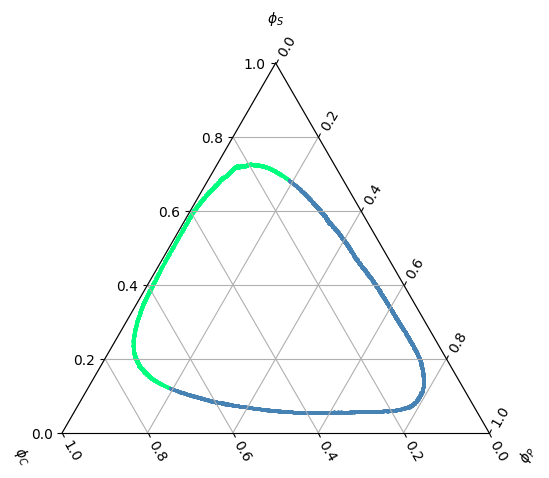

In [25]:
fig = plt.figure()
ax  = fig.add_subplot(projection="ternary")
ax.scatter (some_output[0][:,0], some_output[0][:,2], some_output[0][:,1], color='springgreen'  , s=1)
ax.scatter (some_output[0][:,3], some_output[0][:,5], some_output[0][:,4], color='steelblue', s=1)
ax.set_tlabel("$\\phi _{S}$")
ax.set_llabel("$\\phi _{C}$")
ax.set_rlabel("$\\phi _{P}$")
ax.set_tlim(0,1)
ax.set_llim(0,1)
ax.set_rlim(0,1)
positions = ["tick1", "tick2"]
for position in positions:
    ax.taxis.set_ticks_position(position)
    ax.laxis.set_ticks_position(position)
    ax.raxis.set_ticks_position(position)
ax.grid ()
fig.show()

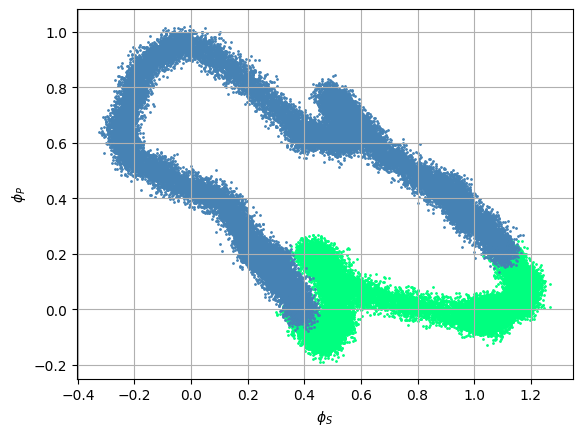

In [19]:
%matplotlib inline
fig = plt.figure()
ax  = plt.axes()
ax.scatter (some_output[0][:,0], some_output[0][:,1], color='springgreen'  , s=1)
ax.scatter (some_output[0][:,3], some_output[0][:,4], color='steelblue', s=1)
ax.set_xlabel("$\\phi _{S}$")
ax.set_ylabel("$\\phi _{P}$")
# ax.set_lim(0,1)
# ax.set_llim(0,1)
# ax.set_rlim(0,1)
ax.grid ()
plt.savefig("test.png", dpi=1200)

In [20]:
np_inputs  = np.array(the_inputs )
np_outputs = np.array(the_outputs)

NameError: name 'np_output' is not defined

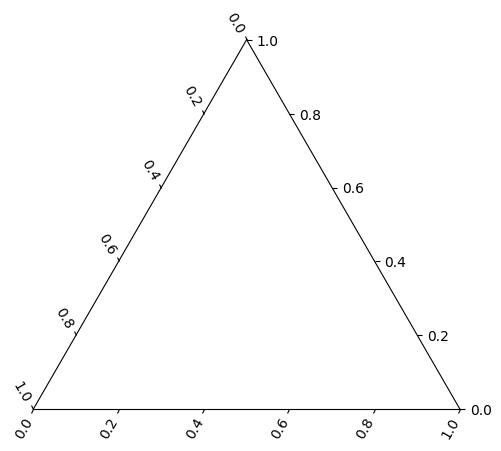

In [21]:
np_inputs[0]
fig = plt.figure()
ax  = fig.add_subplot(projection="ternary")
ax.scatter (np_output[:,0], some_output[:,2], some_output[:,1], color='springgreen'  , s=1)
ax.scatter (np_output[:,3], np_output[:,5], some_output[:,4], color='steelblue', s=1)
ax.set_tlabel("$\\phi _{S}$")
ax.set_llabel("$\\phi _{C}$")
ax.set_rlabel("$\\phi _{P}$")
ax.set_tlim(0,1)
ax.set_llim(0,1)
ax.set_rlim(0,1)
positions = ["tick1", "tick2"]
for position in positions:
    ax.taxis.set_ticks_position(position)
    ax.laxis.set_ticks_position(position)
    ax.raxis.set_ticks_position(position)
ax.grid ()
fig.show()

In [ ]:
df = pd.read_csv("trim.vs_1.0-vc_1.0-vp_2.0-chisc_0.0-chips_-11.0-chipc_-1.0.binodal", sep='\|', names=["phi_s_top","phi_p_top","phi_c_top","phi_s_bot","phi_p_bot","phi_c_bot"], skiprows=1, engine='python')
data = df.values.reshape(40000, 6)

# convery to numpy object
data = np.array(data, dtype=np.float64)

In [ ]:
fig = plt.figure()
ax  = fig.add_subplot(projection="ternary")
ax.scatter (data[:,0], data[:,2], data[:,1], color='springgreen'  , s=1)
ax.scatter (data[:,3], data[:,5], data[:,4], color='steelblue', s=1)
ax.set_tlabel("$\\phi _{S}$")
ax.set_llabel("$\\phi _{C}$")
ax.set_rlabel("$\\phi _{P}$")
ax.set_tlim(0,1)
ax.set_llim(0,1)
ax.set_rlim(0,1)
positions = ["tick1", "tick2"]
for position in positions:
    ax.taxis.set_ticks_position(position)
    ax.laxis.set_ticks_position(position)
    ax.raxis.set_ticks_position(position)
ax.grid ()
fig.show()